# Translational embeddings with PyKEEN

This notebook will set up a basic training procedure for a TransE model using the PyKEEN package. We will use an interaction network for yeast (from the STRING database) together with GO functions of yeast protein to test the embedding function.

For this tutorial to work, install PyKEEN following the instructions at https://github.com/SmartDataAnalytics/PyKEEN.

We start with basic imports and setting up our environment:

In [1]:
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pykeen
from pykeen.kge_models import TransE

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('pykeen').setLevel(logging.INFO)

In [4]:
print(sys.version)

3.6.0 (default, Jul 27 2019, 09:24:03) 
[GCC 8.3.0]


In [5]:
print(time.asctime())

Sat Jul 27 11:21:42 2019


In [6]:
print(pykeen.get_version())

0.0.25


Check which hyper-parameters are required by TransE:

In [7]:
TransE.hyper_params

['embedding_dim',
 'margin_loss',
 'learning_rate',
 'scoring_function',
 'normalization_of_entities']

Define output directory:

In [8]:
output_directory = 'data/'

Define hyper-parameters inclduing the evaluation information:
 * If no test set is available define the ration of the training set that should be used as test set: **test_set_ratio**
 * Define whether you want to compute the metrics (mean rank and hits@k) in raw or in a filtered setting: **filter_negative_triples**
 
 This is the basic set of parameters for a TransE model; other models may require slightly different parameters.
 
 Unless you have a powerful GPU or use a different dataset than the one provided, set the number of epochs to a low number (5 or 10) for this tutorial; when you want to use and apply the model for a prediction task later, train for more epochs (ideally, on a good GPU).

In [54]:
config = dict(
    training_set_path           = 'data/data-train/yeast-plain.nt',
    execution_mode              = 'Training_mode',
    random_seed                 = 2,
    kg_embedding_model_name     = 'TransE',
    embedding_dim               = 50,
    scoring_function            = 1,  # corresponds to L1
    normalization_of_entities   = 2,  # corresponds to L2
    margin_loss                 = 3,
    learning_rate               = 0.1,
    num_epochs                  = 10,  
    batch_size                  = 32,
    filter_negative_triples     = True,
    preferred_device            = 'gpu'
)

### Train TransE:

In [55]:
results = pykeen.run(
    config=config,
    output_directory=output_directory,
)

INFO:pykeen.utilities.pipeline:-------------Train KG Embeddings-------------
Training epoch: 100%|██████████| 10/10 [06:19<00:00, 37.99s/it]


### Check result entries:

In [56]:
results.results.keys()

odict_keys(['trained_model', 'losses', 'entity_to_embedding', 'relation_to_embedding', 'entity_to_id', 'relation_to_id', 'final_configuration'])

### Losses

This plot shows us how well our model learns. We can see that the loss is still increasing, so we should try again with a higher number of epochs. We would stop training when we our loss is no longer decreasing (may take hundreds or thousands of epochs).

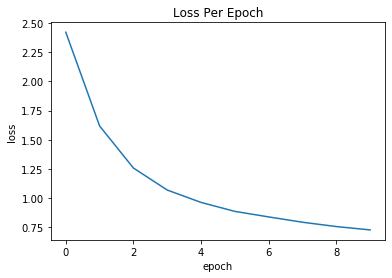

In [57]:
losses = results.results['losses']
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

### Save embeddings:

In [58]:
import pandas as pd

classes = list(results.results['entity_to_embedding'].keys())
cls_embeds = list(results.results['entity_to_embedding'].values())

df = pd.DataFrame({'classes': classes, 'embeddings': cls_embeds})
df.to_pickle('data/transe/cls_embeddings.pkl')

relations = list(results.results['relation_to_embedding'].keys())
rel_embeds = list(results.results['relation_to_embedding'].values())
df = pd.DataFrame({'relations': relations, 'embeddings': rel_embeds})
df.to_pickle('data/transe/rel_embeddings.pkl')


### Evaluation results on test set:
 * Hits@k, k $\in$ {10, 100}
 * Mean rank
 * ROC AUC

In [59]:
from scipy.stats import rankdata

def load_test_data(data_file, classes, relations):
    data = []
    rel = f'http://interacts'
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'http://{it[0]}'
            id2 = f'http://{it[1]}'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((id1, rel, id2))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc

cls_df = pd.read_pickle('data/transe/cls_embeddings.pkl')
rel_df = pd.read_pickle('data/transe/rel_embeddings.pkl')
classes = {v: k for k, v in enumerate(cls_df['classes'])}
relations = {v: k for k, v in enumerate(rel_df['relations'])}

nb_classes = len(cls_df)
nb_relations = len(rel_df)
embeds_list = cls_df['embeddings'].values
rembeds_list = rel_df['embeddings'].values
size = len(embeds_list[0])
embeds = np.zeros((nb_classes, size), dtype=np.float32)
for i, emb in enumerate(embeds_list):
    embeds[i, :] = emb

proteins = {}
for k, v in classes.items():
    if not k.startswith('<http://purl.obolibrary.org/obo/GO_'):
        proteins[k] = v

prot_index = list(proteins.values())
prot_embeds = embeds[prot_index, :]
prot_dict = {v: k for k, v in enumerate(prot_index)}
    
rsize = len(rembeds_list[0])
rembeds = np.zeros((nb_relations, rsize), dtype=np.float32)
for i, emb in enumerate(rembeds_list):
    rembeds[i, :] = emb

train_data = load_test_data('data/data-train/4932.protein.links.v10.5.txt', classes, relations)
valid_data = load_test_data('data/data-valid/4932.protein.links.v10.5.txt', classes, relations)
trlabels = {}
for c, r, d in train_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000
for c, r, d in valid_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000

test_data = load_test_data('data/data-test/4932.protein.links.v10.5.txt', classes, relations)
top1 = 0
top10 = 0
top100 = 0
mean_rank = 0
ftop1 = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
labels = {}
preds = {}
ranks = {}
franks = {}
eval_data = test_data
n = len(eval_data)
for c, r, d in eval_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in labels:
        labels[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    if r not in preds:
        preds[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.float32)
    labels[r][c, d] = 1
    ec = prot_embeds[c, :]
    er = rembeds[r, :]
    ec += er

    # Compute distance
    dst = np.linalg.norm(prot_embeds - ec.reshape(1, -1), axis=1)
    res = dst.flatten()

    preds[r][c, :] = res
    index = rankdata(res, method='average')
    rank = index[d]
    if rank == 1:
        top1 += 1
    if rank <= 10:
        top10 += 1
    if rank <= 100:
        top100 += 1
    mean_rank += rank
    if rank not in ranks:
        ranks[rank] = 0
    ranks[rank] += 1

    # Filtered rank
    index = rankdata((res * trlabels[r][c, :]), method='average')
    rank = index[d]
    if rank == 1:
        ftop1 += 1
    if rank <= 10:
        ftop10 += 1
    if rank <= 100:
        ftop100 += 1
    fmean_rank += rank

    if rank not in franks:
        franks[rank] = 0
    franks[rank] += 1
top1 /= n
top10 /= n
top100 /= n
mean_rank /= n
ftop1 /= n
ftop10 /= n
ftop100 /= n
fmean_rank /= n

rank_auc = compute_rank_roc(ranks, len(proteins))
frank_auc = compute_rank_roc(franks, len(proteins))

print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')

0.01 0.11 9421.18 0.81
0.02 0.14 9373.91 0.81


In [61]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
X = TSNE(n_components=2, verbose=1).fit_transform(prot_embeds)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50653 samples in 0.123s...
[t-SNE] Computed neighbors for 50653 samples in 303.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50653
[t-SNE] Computed conditional probabilities for sample 2000 / 50653
[t-SNE] Computed conditional probabilities for sample 3000 / 50653
[t-SNE] Computed conditional probabilities for sample 4000 / 50653
[t-SNE] Computed conditional probabilities for sample 5000 / 50653
[t-SNE] Computed conditional probabilities for sample 6000 / 50653
[t-SNE] Computed conditional probabilities for sample 7000 / 50653
[t-SNE] Computed conditional probabilities for sample 8000 / 50653
[t-SNE] Computed conditional probabilities for sample 9000 / 50653
[t-SNE] Computed conditional probabilities for sample 10000 / 50653
[t-SNE] Computed conditional probabilities for sample 11000 / 50653
[t-SNE] Computed conditional probabilities for sample 12000 / 50653
[t-SNE] Computed conditional probabilities for s

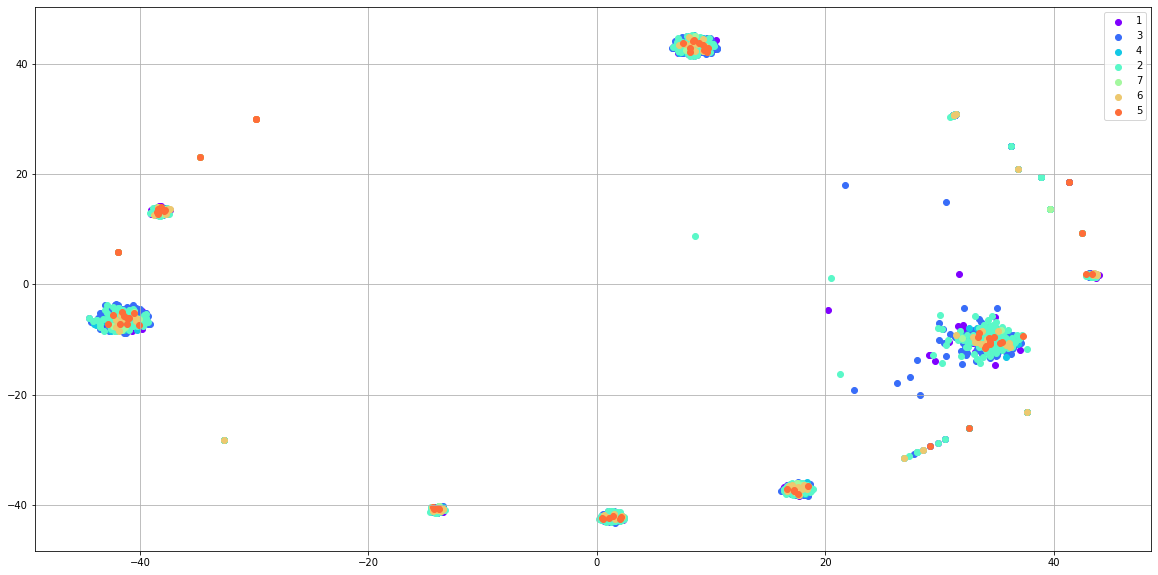

In [62]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = 'http://{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
classes = {'0': [[], []]}
for i, item in enumerate(proteins.items()):
    k, v = item
    if k in ec_numbers:
        ec = ec_numbers[k].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[i, 0])
        classes[ec][1].append(X[i, 1])
colors = iter(cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 10))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()